# Example SED analysis using PyXEM

**author: Mohsen Danaie**


This notebook is intended to be run on Diamond's Jupyter hub. See instructions to connect [here](https://diamondlightsource.atlassian.net/wiki/spaces/EPSICWEB/pages/167346199/Instructions+to+connect+to+Diamond+s+JupyterHub)

This notebook covers the following tasks:

**[(a) Calibrations:](#calibrations)<br>**

   [- setting up and loading files](#setup)<br>
   [- realspace pixel size calibration](#realspace)<br>
   [- reciprocal space pixel size calibration](#recipspace)<br>
   [- correction of diffrcation roundness](#diffroundness)<br>
   [- image / diffraction plane rotation calibration](#scanrot)<br>
   
   
**[(b) PyXEM analysis](#pyxem)<br>**

<a id='calibrations'></a>
**(a) Calibrations** 

<a id='setup'></a>
setting up

You need to run this next cell only if you have a personal install of a package that is different from what is instelled in the epsic3.7 environment (replace fedID with your own):

In [1]:
# import sys
# sys.path.append('/home/fedID/.local/bin')
# sys.path.append('/home/fedID/.local/lib/python3.7/site-packages')

In [2]:
%matplotlib notebook
import numpy as np
import hyperspy.api as hs
import pyxem as pxm
import matplotlib.pyplot as plt

from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

/home/eha56862/.local/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


We may need some of the utilities [here](https://github.com/ePSIC-DLS/epsic_tools). So we clone and import this package (need to run only once):

In [3]:
!git clone https://github.com/ePSIC-DLS/epsic_tools

Cloning into 'epsic_tools'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 1086 (delta 147), reused 214 (delta 56), pack-reused 755
Receiving objects: 100% (1086/1086), 14.85 MiB | 3.83 MiB/s, done.
Resolving deltas: 100% (573/573), done.
Updating files: 100% (100/100), done.


In [3]:
import os
import sys
current_path = os.getcwd()
sys.path.append(os.path.join(current_path, 'epsic_tools'))
import epsic_tools.api as epsic

loading files

In [5]:
base_folder = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/' 
cals_path = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals'
mask_path = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/mask.hspy'

In [6]:
hdf_files = []
hspy_files = []
tiff_files = []
for dirname, dirnames, filenames in os.walk(cals_path):
    for filename in filenames:
        if os.path.splitext(filename)[1] == '.hdf5':
            hdf_files.append(os.path.join(dirname, filename))
        if os.path.splitext(filename)[1] == '.hspy':
            hspy_files.append(os.path.join(dirname, filename))
        if os.path.splitext(filename)[1] == '.tiff':
            tiff_files.append(os.path.join(dirname, filename))
for i, file in enumerate(hspy_files):
    print('[', i, ']', file.split('/')[-1])

[ 0 ] calibrated_dp.hspy
[ 1 ] mask.hspy
[ 2 ] vac_pattern.hspy
[ 3 ] au_xgrating_200kX_40cmCL_10umAp_subset_dp.hspy
[ 4 ] au_xgrating_200kX_40cmCL_10umAp_ibf.hspy
[ 5 ] defocus_scan_au_xgrating_200kX_40cmCL_10umAp_subset_dp.hspy
[ 6 ] defocus_scan_au_xgrating_200kX_40cmCL_10umAp_ibf.hspy
[ 7 ] defocus_scan_au_xgrating_200kX_40cmCL_10umAp_scan_array_125by127_diff_plane_515by515_flip.hspy
[ 8 ] binned_nav_au_xgrating_200kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 9 ] au_xgrating_200kX_20cmCL_10umAp_ibf.hspy
[ 10 ] au_xgrating_200kX_20cmCL_10umAp_subset_dp.hspy
[ 11 ] binned_nav_au_xgrating_100kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 12 ] au_xgrating_100kX_20cmCL_10umAp_ibf.hspy
[ 13 ] au_xgrating_100kX_20cmCL_10umAp_subset_dp.hspy
[ 14 ] binned_nav_au_xgrating_150kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 15 ] au_xgrating_150kX_20cmCL_10umAp_subset_dp.hspy
[ 16 ] au_xgrating_150kX_20cmCL_10umAp_ibf.hspy

<a id='realspace'></a>
**real space pixel size**

<IPython.core.display.Javascript object>


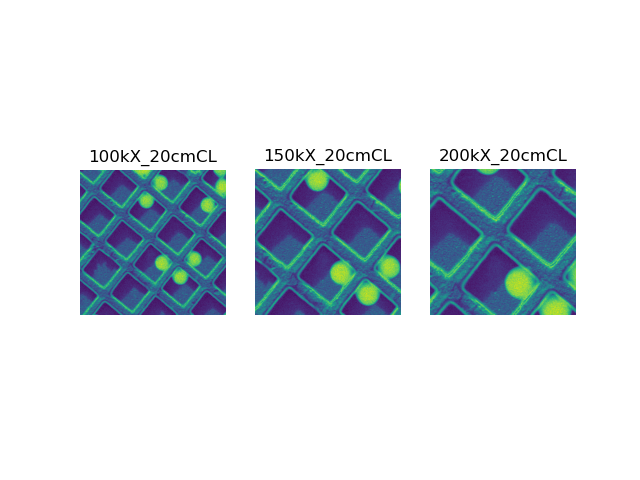

(-0.5, 254.5, 254.5, -0.5)

In [7]:
au_refImages = []

for file in hspy_files:
    if 'au_xgrating_100kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    if 'au_xgrating_150kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    if 'au_xgrating_200kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    

auRefIm = pxm.load(au_refImages)

plt.figure()
plt.subplot(131, title = '100kX_20cmCL')
plt.imshow(auRefIm[1].data)
plt.axis('off')
plt.subplot(132, title = '150kX_20cmCL')
plt.imshow(auRefIm[2].data)
plt.axis('off')
plt.subplot(133, title = '200kX_20cmCL')
plt.imshow(auRefIm[0].data)
plt.axis('off')


measure pixel sizes - interactively:

In [8]:
im= auRefIm[1]
im.plot()
line = pxm.roi.Line2DROI(x1=68.7, y1=213.96, x2=189.9, y2=64.167, linewidth=10)
line.add_widget(im)      
trace = line.interactive(im)
trace.plot()

<IPython.core.display.Javascript object>

using interactive roi


<IPython.core.display.Javascript object>

In [9]:
MAG = [
    '100kX',
    '150kX',
    '200kX'
]
# pitch of the au cross-grating is 500 nm
nm_per_pixel = [
        np.mean([500 / (101-36.5),500 / (164.7-101)]),
        np.mean([500 / (109.46 - 14.91),500 / (205.97 - 109.46)]),
        np.mean([500 / (134.57 - 10.31),500 / (263.27 - 134.57)])
 ]
FOV = np.asarray(nm_per_pixel) * 256
#dictionary of MAG cal - MAG keys and FOV in nm values
MAG_cal_FOV = dict(zip(MAG, FOV))
print(MAG_cal_FOV)
# save to a file
np.save('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/MAG_cal_FOV_nm.npy', MAG_cal_FOV)

{'100kX': 1996.9576381536517, '150kX': 1340.034249786069, '200kX': 1012.3295878969468}


We can then fit a function to the above data points to get calibrated pixel size for MAGs not measured:

In [10]:
from scipy.optimize import curve_fit

x = [100000, 150000, 200000]
y = [1996.96, 1340.03, 1012.33]


def inv_fun(x, a, b):
    return a / x + b

popt, pcov = curve_fit(inv_fun, x, y)

In [11]:
MAG = 120000
FOV = inv_fun(MAG, popt[0], popt[1])
print(FOV)

1668.6042857135553


<a id='recipspace'></a>
**reciprocal space pixel size**

Would be helpful to create sum dp images with better "dynamic range" (need running once):

In [12]:
bin_nav = []
a = ['binned_nav', '20cmCL']
for file in hdf_files:
    if all(x in file for x in a):
        bin_nav.append(file)
for file in bin_nav:
    d = pxm.load(file, lazy = True)
    d_sum = d.sum()
    d_sum.save(os.path.dirname(file) + '/' + os.path.splitext(os.path.basename(file))[0]+'_sumdiff')
    del d, d_sum

Overwrite '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113904/binned_nav_au_xgrating_200kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy' (y/n)?
n


Overwrite '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113346/binned_nav_au_xgrating_100kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy' (y/n)?
n


Overwrite '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/binned_nav_au_xgrating_150kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy' (y/n)?
n


Reference diffraction data, only using 20 cm CL cases:

In [13]:
au_refDiff = []
for file in hspy_files:
    if '_sumdiff' in file:
        au_refDiff.append(file)
auRefDiff = pxm.load(au_refDiff)

v_max = 15
plt.figure()
plt.subplot(131, title = '100kX_20cmCL')
plt.imshow(np.log(auRefDiff[2].data), vmax = v_max)
plt.axis('off')
plt.subplot(132, title = '150kX_20cmCL')
plt.imshow(np.log(auRefDiff[1].data), vmax = v_max)
plt.axis('off')
plt.subplot(133, title = '200kX_20cmCL')
plt.imshow(np.log(auRefDiff[2].data), vmax = v_max)
plt.axis('off')


<IPython.core.display.Javascript object>

(-0.5, 514.5, 514.5, -0.5)

It should not matter which one we choose to analyse here. So continuing with the first pattern:

In [14]:
dp = auRefDiff[0]

dp = pxm.ElectronDiffraction2D(dp)
dp.plot(vmax = 8000)

<IPython.core.display.Javascript object>

Lets do a rough measurement of pixel size in reciprocal space - interactively:

<IPython.core.display.Javascript object>

using interactive roi


<IPython.core.display.Javascript object>


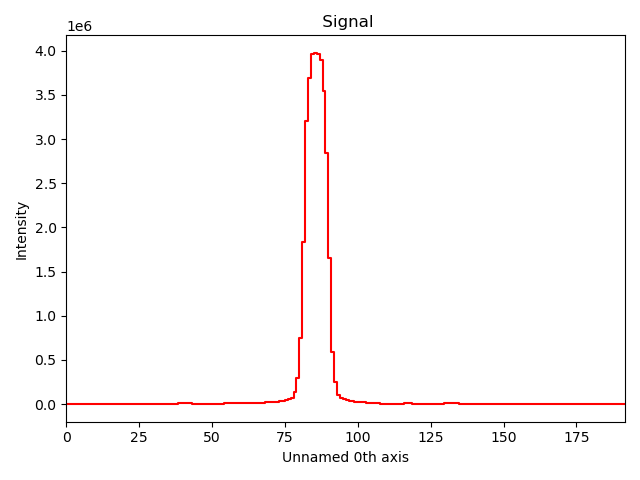

In [15]:
dp.plot(vmax=8000)
line = pxm.roi.Line2DROI(x1=186.251, y1=342.793, x2=307.451, y2=193.00, linewidth=5)
line.add_widget(dp)      

trace = line.interactive(dp)
trace.plot()

In [16]:
# centre : 240, 275.5
# 111 ring diam in pixels: 92 - radius 46
# Au 111 reflection (A^-1): 1 / 2.355
diff_cal = (1/2.355) / 46
print(np.round(diff_cal, decimals=5), 'A^-1 to pix')

0.00923 A^-1 to pix


The above value is a rough initial estimate. We will refine this value later in the notebook.

<a id='diffroundness'></a>
**Diffraction roundness correction**

First we create a smaller dataset by skipping a number of probe positions, e.g. 10 here:

In [17]:
file = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_.hdf5'
dp_full = pxm.load(file, lazy = True)
print(dp_full)

<LazySignal2D, title: , dimensions: (255, 255|515, 515)>


In [18]:
dp_skip10 = dp_full.inav[::10,::10]
dp_skip10.save('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10.hdf5')

Overwrite '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10.hdf5' (y/n)?
n


In [20]:
# dp_skip10= pxm.load_hspy('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10.hdf5')

Loading the mask and applying it to the skip10 data:

<IPython.core.display.Javascript object>


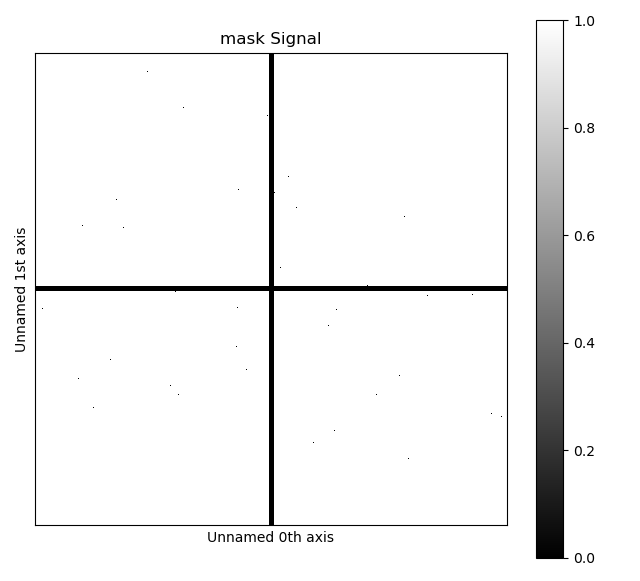

In [19]:
mask = pxm.load(mask_path)
mask.plot()
dp_skip10_masked = dp_skip10 * mask
dp_skip10_masked = pxm.ElectronDiffraction2D(dp_skip10_masked)
dp_skip10_masked_sum = dp_skip10_masked.sum()

We need to have the central beam at the centre of the diffraction patterns to continue with this snalysis. Here we find the centre of the pattern on the sum diffraction pattern and crop around this position:

In [20]:
centre = pxm.utils.expt_utils.find_beam_center_interpolate(dp_skip10_masked_sum, sigma=5, upsample_factor=4, kind='linear')
print('Coordinates of the centre: ', centre)

Coordinates of the centre:  [241.25 276.25]


Crop the diffraction patterns to square with the direct beam at centre:

In [21]:
det_size = dp_skip10_masked_sum.axes_manager[0].size
crop_size = min(int(det_size - centre[0]),int(det_size - centre[1]), centre[0], centre[1])
print('croped size of the patterns: ', int(2 * crop_size))
dp_skip10_masked_crop = dp_skip10_masked.isig[int(centre[0]-crop_size):int(centre[0]+crop_size), int(centre[1]-crop_size):int(centre[1]+crop_size)]

croped size of the patterns:  476


In [22]:
dp_skip10_masked_crop.axes_manager

<Axes manager, axes: (26, 26|476, 476)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |     26 |      0 |       0 |       1 | <undefined> 
     <undefined> |     26 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    476 |        |       3 |       1 | <undefined> 
     <undefined> |    476 |        |      38 |       1 | <undefined>

In [23]:
shifts = dp_skip10_masked.get_direct_beam_position(method='interpolate', sigma=5, upsample_factor=4, kind='linear')

You can inspect the shift values by calling: shifts.data

In [26]:
dp_skip10_masked_crop.center_direct_beam(method='interpolate', sigma=5, upsample_factor=4, kind='linear')

In [27]:
dp_skip10_masked_crop.axes_manager[2].offset = 0
dp_skip10_masked_crop.axes_manager[3].offset = 0

<IPython.core.display.Javascript object>


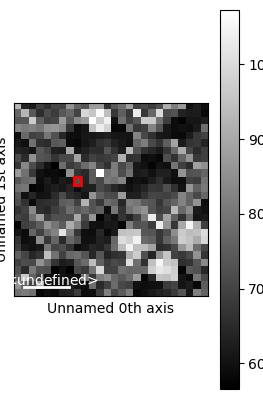

<IPython.core.display.Javascript object>


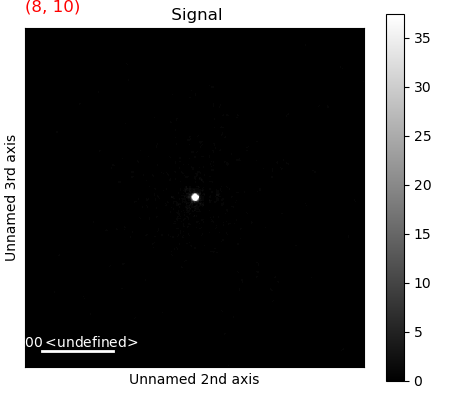

In [28]:
dp_skip10_masked_crop.plot()

saving a centred version:

In [85]:
dp_skip10_masked_crop.save('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10_centred.hdf5')

Overwrite '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10_centred.hdf5' (y/n)?
y


<IPython.core.display.Javascript object>


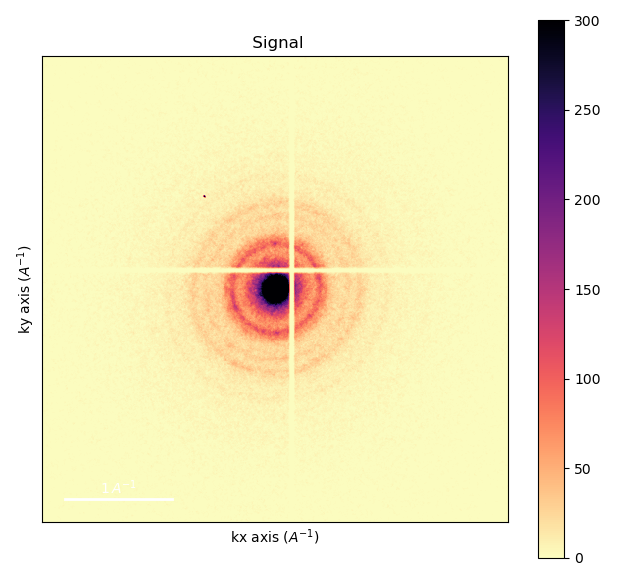

In [29]:
dp_sum = dp_skip10_masked_crop.sum()
dp_sum = pxm.ElectronDiffraction2D(dp_sum)
dp_sum.set_experimental_parameters(beam_energy=300, camera_length=20.)
dp_sum.set_diffraction_calibration(calibration=diff_cal)
cal_lib = CalibrationDataLibrary(au_x_grating_dp=dp_sum)
cal = CalibrationGenerator(calibration_data=cal_lib)
dp_sum.plot(vmax = 300, cmap='magma_r')

In [30]:
cal.get_elliptical_distortion(mask_radius=10,
                              scale=diff_cal, amplitude=4e4,
                              asymmetry=0.9,spread=2)

array([[1.01907233, 0.0176075 , 0.        ],
       [0.0176075 , 1.01625517, 0.        ],
       [0.        , 0.        , 1.        ]])

In [31]:
corr_matrix = cal.get_correction_matrix()

<IPython.core.display.Javascript object>


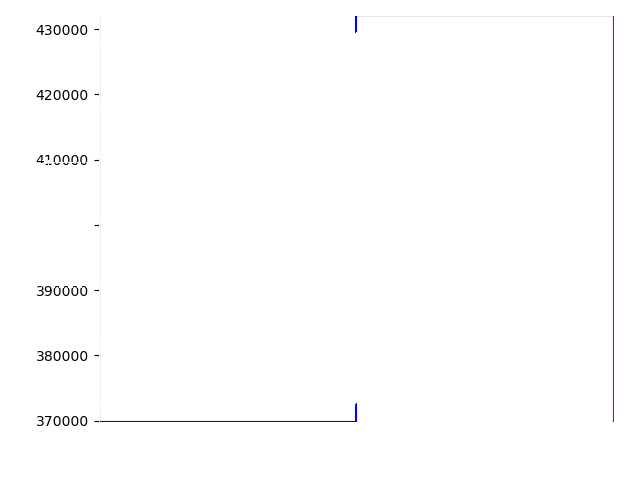

<IPython.core.display.Javascript object>


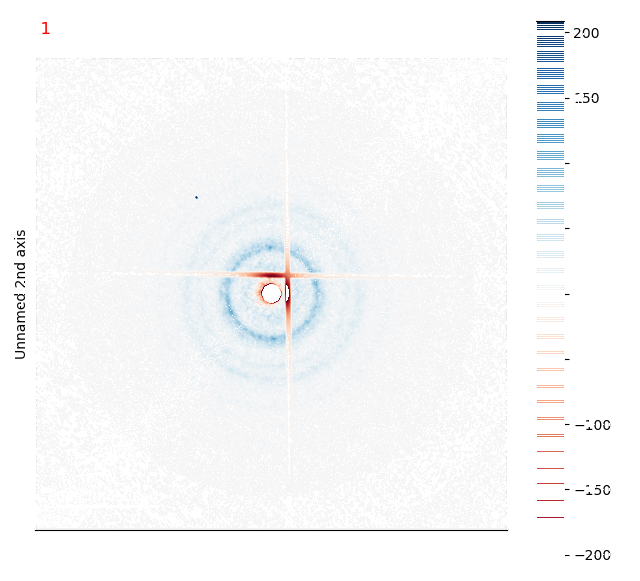

In [32]:
residuals = cal.get_distortion_residuals(mask_radius=10, spread=2)
residuals.plot(cmap='RdBu', vmax=0.04)

<IPython.core.display.Javascript object>


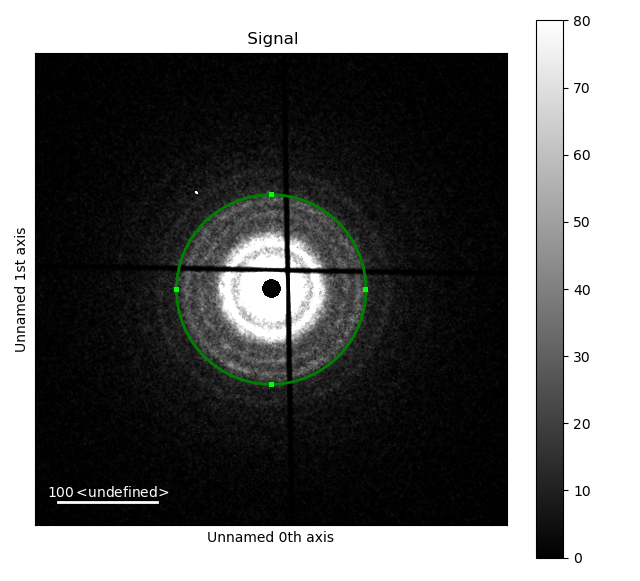

In [33]:
cal.plot_corrected_diffraction_pattern(vmax= 80)


Now we can refine the reciprocal space pixel size

In [34]:
centre = (int((dp_sum.data.shape[0]/2)), int((dp_sum.data.shape[1]/2)))
profile = epsic.radial_profile.radial_profile(dp_sum.data, centre)

<IPython.core.display.Javascript object>


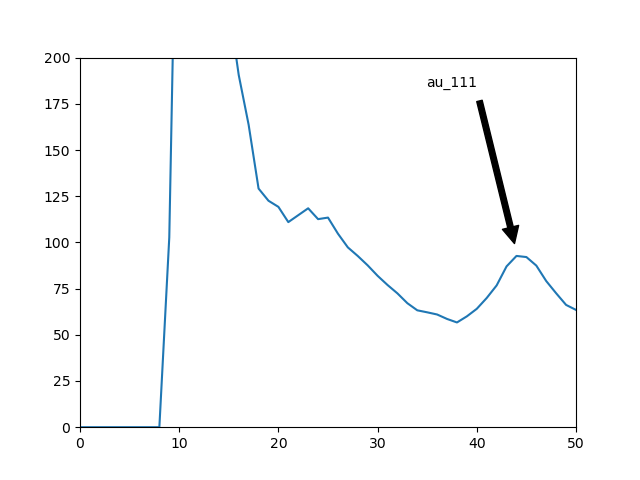

Text(0.8, 0.95, 'au_111')

In [35]:
fig, ax = plt.subplots(1,1)
ax.plot(profile)
ax.set_xlim([0, 50])
ax.set_ylim([0, 200])
ax.annotate('au_111', xy=(44, 95),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

In [36]:
diff_cal_refined = (1/2.355) / 44.4
print(np.round(diff_cal,5), 'A^-1 to pix')
print(np.round(diff_cal_refined,5), 'A^-1 to pix')

0.00923 A^-1 to pix
0.00956 A^-1 to pix


<a id='scanrot'></a>
**Scan rotation calibration**

In [60]:
raw = hs.load('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 115307/defocus_scan_au_xgrating_200kX_40cmCL_10umAp_scan_array_125by127_diff_plane_515by515_.hdf5')

In [61]:
raw_flip = np.flip(raw.data, axis = 3)

In [63]:
raw_flip = hs.signals.Signal2D(raw_flip)

In [64]:
raw_flip.save('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 115307/defocus_scan_au_xgrating_200kX_40cmCL_10umAp_scan_array_125by127_diff_plane_515by515_flip_2')

In [4]:
scan_data = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 115307/from_mg25142-9/20201214_153300.hdf5'

In [5]:
scan = pxm.load(scan_data, lazy = True)

In [6]:
scan.metadata

├── General
│   └── title = 
└── Signal
    ├── binned = False
    ├── exposure_time = 0.001
    ├── flip = True
    ├── flyback_times = [0.074798, 0.068, 0.053, 0.054]
    ├── frames_number_skipped = 127
    ├── scan_X = 128
    └── signal_type = electron_diffraction

In [7]:
scan.axes_manager

<Axes manager, axes: (127, 127|515, 515)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |    127 |      0 | 1.3e+02 |       1 | <undefined> 
     <undefined> |    127 |      0 | 1.3e+02 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    515 |        |       0 |       1 | <undefined> 
     <undefined> |    515 |        |       0 |       1 | <undefined>

In [11]:
fast_dir = scan.inav[1:,60]
slow_dir = scan.inav[60,1:]
fast_dir.compute()
slow_dir.compute()

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s


<IPython.core.display.Javascript object>


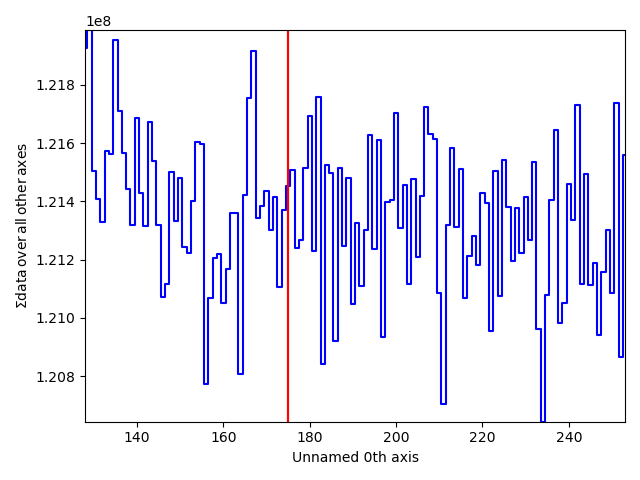

<IPython.core.display.Javascript object>


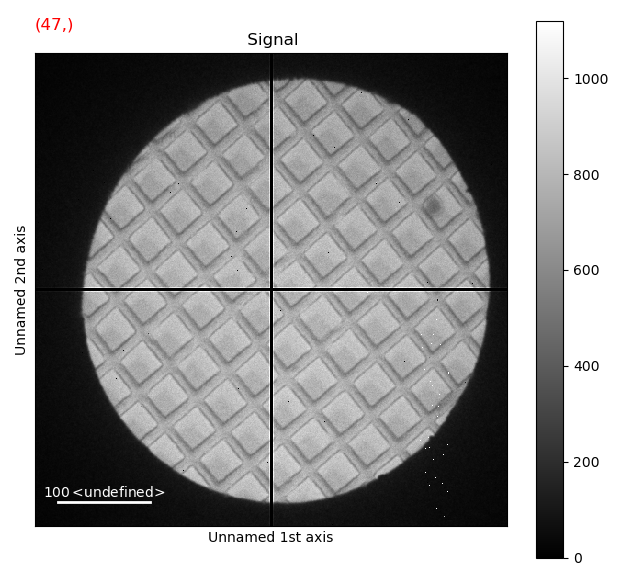

In [12]:
slow_dir.plot()

In [13]:
fast_dir.axes_manager

<Axes manager, axes: (126|515, 515)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |    126 |      0 | 1.3e+02 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    515 |        |       0 |       1 | <undefined> 
     <undefined> |    515 |        |       0 |       1 | <undefined>

Cropping to the area within the bright-field disc and removing the cross:

In [14]:
index = [255,256,257,258,259]
fast_dir_no_cross = np.delete(fast_dir.data, index, axis = 1)
fast_dir_no_cross = np.delete(fast_dir_no_cross, index, axis = 2)
slow_dir_no_cross = np.delete(slow_dir.data, index, axis = 1)
slow_dir_no_cross = np.delete(slow_dir_no_cross, index, axis = 2)

In [15]:
fast_dir_no_cross = hs.signals.Signal2D(fast_dir_no_cross)
slow_dir_no_cross = hs.signals.Signal2D(slow_dir_no_cross)

In [16]:
fast_dir_crop = fast_dir_no_cross.isig[132:429, 108:415]
slow_dir_crop = slow_dir_no_cross.isig[132:429, 108:415]

<IPython.core.display.Javascript object>


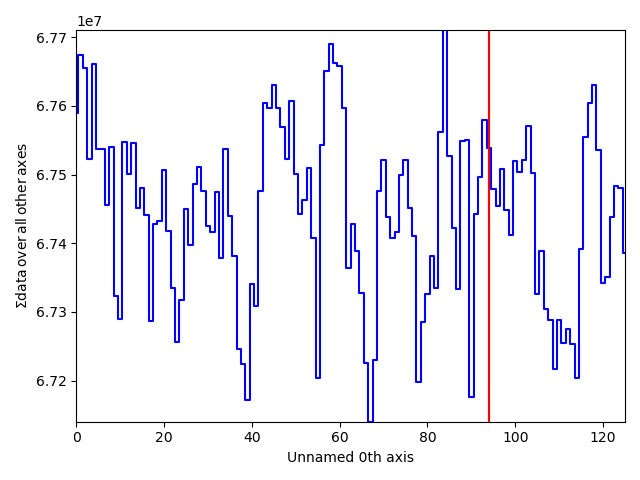

<IPython.core.display.Javascript object>


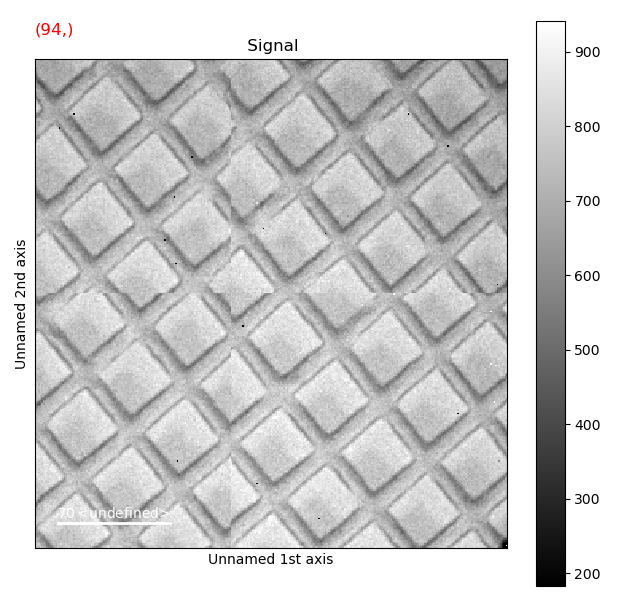

In [17]:
fast_dir_crop.plot()

Applying a blur to better track the motion:

<IPython.core.display.Javascript object>


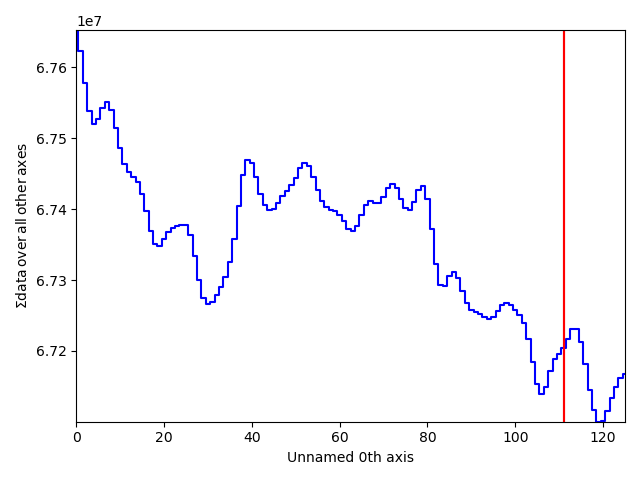

<IPython.core.display.Javascript object>


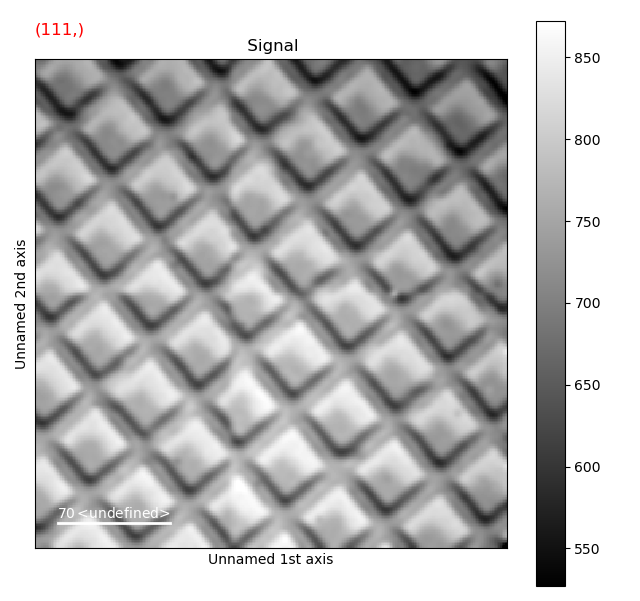

In [94]:
from scipy.ndimage import gaussian_filter
fast_dir_crop_gb = gaussian_filter(fast_dir_crop.data, sigma = 2)
fast_dir_crop_gb = hs.signals.Signal2D(fast_dir_crop_gb)
slow_dir_crop_gb = gaussian_filter(slow_dir_crop.data, sigma = 2)
slow_dir_crop_gb = hs.signals.Signal2D(slow_dir_crop_gb)
slow_dir_crop_gb.plot()

In [27]:
fast_dir_crop_gb.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
shifts_slow = slow_dir_crop_gb.inav[:20].estimate_shift2D('current', roi = (132,292,150,300), normalize_corr=True)
shifts_fast = fast_dir_crop_gb.inav[:20].estimate_shift2D('current', roi = (132,292,150,300), normalize_corr=True)

In [80]:
shifts_slow = np.asarray(shifts_slow)
print(np.sum(shifts_slow, axis=0))
shifts_slow_sum = np.sum(shifts_slow, axis=0)
shifts_fast = np.asarray(shifts_fast)
print(np.sum(shifts_fast, axis=0))
shifts_fast_sum = np.sum(shifts_fast, axis=0)

[ 42 160]
[-170   30]


In [81]:
shifts_slow_sum

array([ 42, 160])

<IPython.core.display.Javascript object>


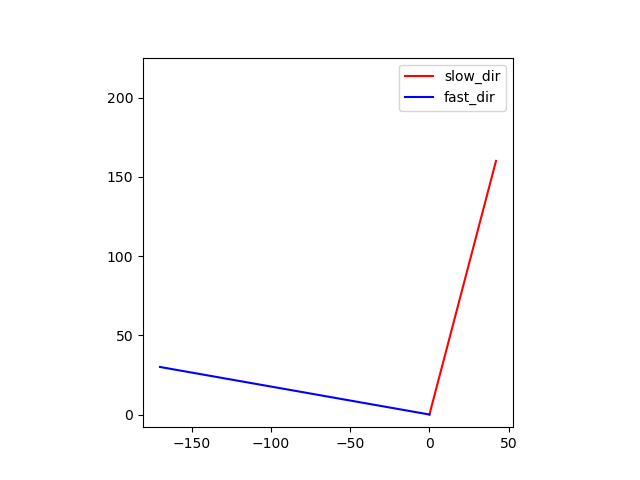

In [89]:
plt.figure()
plt.plot([0, shifts_slow_sum[0]], [0, shifts_slow_sum[1]], '-r', label = 'slow_dir')
plt.plot([0, shifts_fast_sum[0]], [0, shifts_fast_sum[1]], '-b', label = 'fast_dir') 
plt.axis('square')
plt.legend()

In [91]:
math.degrees(math.atan(30/170))

10.007979801441339

In [92]:
math.degrees(math.atan(160/42))

75.29169610031725

In [93]:
180-10.0-75.3

94.7

In [97]:
import scipy

<IPython.core.display.Javascript object>


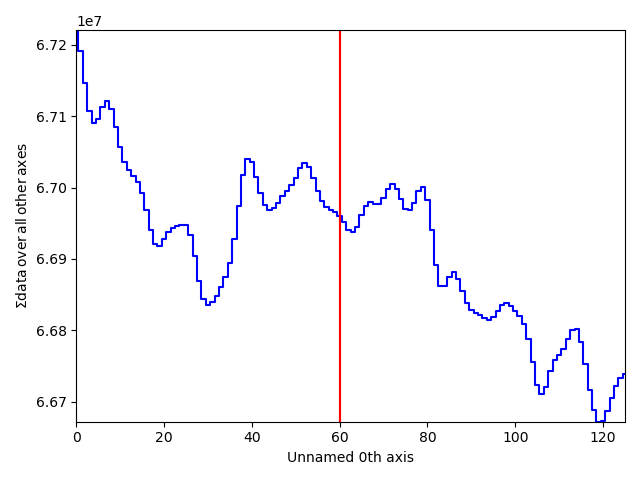

<IPython.core.display.Javascript object>


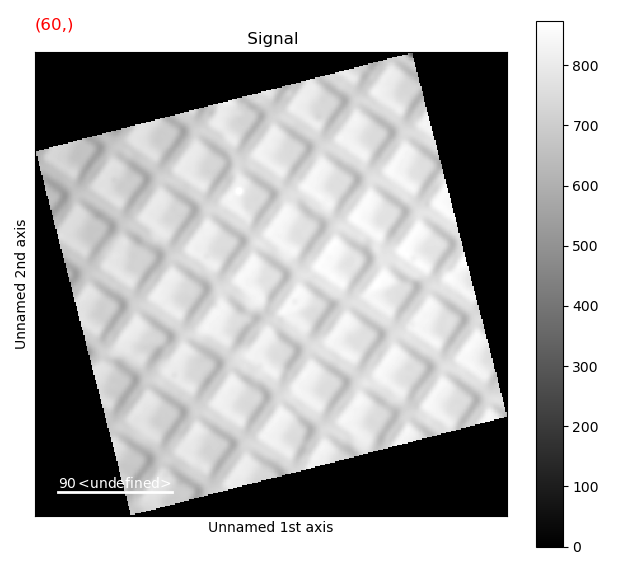

In [101]:
slow_dir_crop_gb_rot = scipy.ndimage.rotate(slow_dir_crop_gb.data, angle=10.0 + 94.7, axes = (1,2))
slow_dir_crop_gb_rot = hs.signals.Signal2D(slow_dir_crop_gb_rot)
slow_dir_crop_gb_rot.plot()

<IPython.core.display.Javascript object>


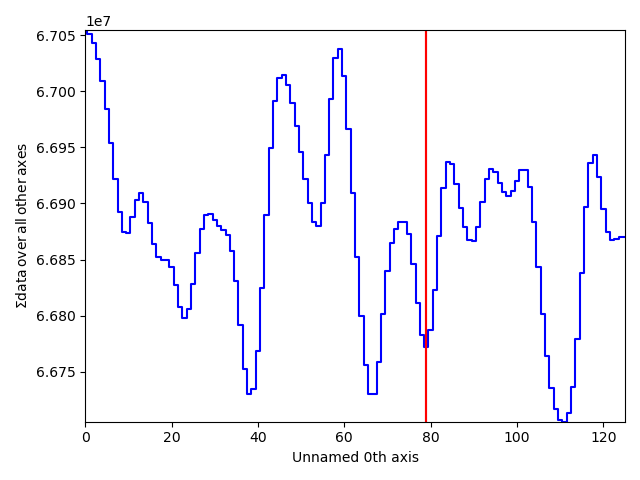

<IPython.core.display.Javascript object>


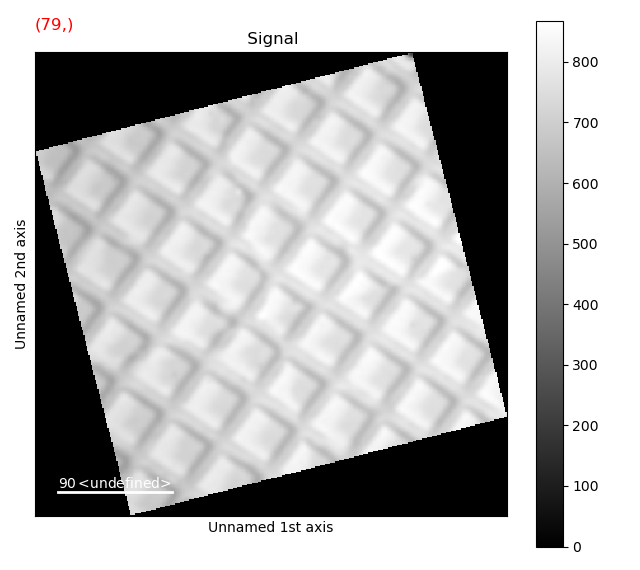

In [103]:
fast_dir_crop_gb_rot = scipy.ndimage.rotate(fast_dir_crop_gb.data, angle=10.0+94.7, axes = (1,2))
fast_dir_crop_gb_rot = hs.signals.Signal2D(fast_dir_crop_gb_rot)
fast_dir_crop_gb_rot.plot()